In [86]:
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import requests
import alpha_vantage
import sys
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [3]:
def get_eod_data (symbol, start_date, end_date, session=None):
    if session is None:
        session = requests.Session()
    base_url = f'https://eodhistoricaldata.com/api/eod/{symbol}?'
     
    params = {
        "api_token": '5f2bfeb6b41b07.67818237',
        "period": 'd',
        "order": 'a',
        "from": start_date, 
        "to": end_date 
    }        
    r = session.get(base_url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0], index_col=0, engine='python')
        return df
    else:
        raise Exception(r.status_code, r.reason, url)

data = get_eod_data (symbol='AXKO.INDX', start_date = (dt.date.today() - dt.timedelta(11*365)).isoformat(), end_date = dt.date.today().isoformat())
data.head()

,Open,High,Low,Close,Adjusted_close,Volume
Date,,,,,,
2019-08-07,6430.0,6482.2,6420.6,6471.8,6471.8,774948928.0
2019-08-08,6471.8,6522.6,6416.8,6522.6,6522.6,865209280.0
2019-08-09,6522.6,6546.5,6517.9,6539.2,6539.2,791900672.0
2019-08-12,6539.2,6543.9,6510.6,6543.9,6543.9,592468672.0
2019-08-13,6543.9,6546.8,6513.3,6523.2,6523.2,829313920.0


In [4]:
data.shape

(257, 6)

In [5]:
data.sort_index()
data.reset_index(level=0, inplace=True)

In [6]:
data.tail()

,Date,Open,High,Low,Close,Adjusted_close,Volume
252,2020-08-04,5890.8,6022.1,5890.8,6001.0,6001.0,847699968.0
253,2020-08-05,6001.0,6001.0,5931.3,5967.3,5967.3,807480000.0
254,2020-08-06,5967.3,6015.5,5967.3,6007.8,6007.8,868240000.0
255,2020-08-07,6007.8,6007.8,5968.1,5989.5,5989.5,185124336.0
256,14194,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            257 non-null    object 
 1   Open            256 non-null    float64
 2   High            256 non-null    float64
 3   Low             256 non-null    float64
 4   Close           256 non-null    float64
 5   Adjusted_close  256 non-null    float64
 6   Volume          256 non-null    float64
dtypes: float64(6), object(1)
memory usage: 14.2+ KB


In [10]:
data['Date'] =  pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekDay'] = data['Date'].dt.weekday+1
data.tail()

,Date,Open,High,Low,Close,Adjusted_close,Volume,Year,Month,Day,WeekDay
252,2020-08-03,5894.1,5911.7,5827.2,5890.8,5890.8,882529984.0,2020,8,3,1
253,2020-08-04,5890.8,6022.1,5890.8,6001.0,6001.0,847699968.0,2020,8,4,2
254,2020-08-05,6001.0,6001.0,5931.3,5967.3,5967.3,807480000.0,2020,8,5,3
255,2020-08-06,5967.3,6015.5,5967.3,6007.8,6007.8,868240000.0,2020,8,6,4
256,2020-08-07,6007.8,6007.8,5968.1,5989.5,5989.5,185124336.0,2020,8,7,5


In [11]:
data[data['Volume'] == 0]['WeekDay'].value_counts()

Series([], Name: WeekDay, dtype: int64)

In [12]:
data['Date'].iloc[0]

Timestamp('2019-08-07 00:00:00')

In [13]:
data['Date'].iloc[-1]

Timestamp('2020-08-07 00:00:00')

In [14]:
print (len(data))
print (data.shape[0])

256
256


In [15]:
data.rename(columns={"Adjusted_close": "Adj_Close"}, inplace=True)
basefile_columns = data.columns.tolist()

In [16]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
Year         0
Month        0
Day          0
WeekDay      0
dtype: int64

In [17]:
data['Pct_Chg_Price'] = data['Adj_Close'].pct_change()
data['Pct_Chg_Volume'] = data['Volume'].pct_change()
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Month,Day,WeekDay,Pct_Chg_Price,Pct_Chg_Volume
1,2019-08-07,6430.0,6482.2,6420.6,6471.8,6471.8,774948928.0,2019,8,7,3,NaN,NaN
2,2019-08-08,6471.8,6522.6,6416.8,6522.6,6522.6,865209280.0,2019,8,8,4,0.007849,0.116473
3,2019-08-09,6522.6,6546.5,6517.9,6539.2,6539.2,791900672.0,2019,8,9,5,0.002545,-0.084729
4,2019-08-12,6539.2,6543.9,6510.6,6543.9,6543.9,592468672.0,2019,8,12,1,0.000719,-0.251840
5,2019-08-13,6543.9,6546.8,6513.3,6523.2,6523.2,829313920.0,2019,8,13,2,-0.003163,0.399760


In [19]:
data['MovAvgPrice_5'] = 0.0
data['MovAvgPrice_20'] = 0.0
data['MovAvgPrice_50'] = 0.0
data['MovAvgPrice_90'] = 0.0
data['MovAvgPrice_120'] = 0.0
#data['MovAvgPrice_200'] = 0.0

data['StdDevPrice_5'] = 0.0
data['StdDevPrice_20'] = 0.0
data['StdDevPrice_50'] = 0.0
data['StdDevPrice_90'] = 0.0
data['StdDevPrice_120'] = 0.0
#data['StdDevPrice_200'] = 0.0

data['MovAvgVol_5'] = 0.0
data['MovAvgVol_20'] = 0.0
data['MovAvgVol_50'] = 0.0
data['MovAvgVol_90'] = 0.0
data['MovAvgVol_120'] = 0.0
#data['MovAvgVol_200'] = 0.0

data['StdDevVol_5'] = 0.0
data['StdDevVol_20'] = 0.0
data['StdDevVol_50'] = 0.0
data['StdDevVol_90'] = 0.0
data['StdDevVol_120'] = 0.0
#data['StdDevVol_200'] = 0.0

for index, row in data.iterrows():
    
    last_week = data.loc[:index-1].tail(5)
    last_month = data.loc[:index-1].tail(20)
    last_bimonthly = data.loc[:index-1].tail(50)
    last_qtr = data.loc[:index-1].tail(90)
    last_half_year = data.loc[:index-1].tail(120)
#    last_year = data.loc[:index-1].tail(200)
    
    data.loc[index,'MovAvgPrice_5'] = np.mean(last_week.Adj_Close.values)
    data.loc[index,'MovAvgPrice_20'] = np.mean(last_month.Adj_Close.values)
    data.loc[index,'MovAvgPrice_50'] = np.mean(last_bimonthly.Adj_Close.values)
    data.loc[index,'MovAvgPrice_90'] = np.mean(last_qtr.Adj_Close.values)
    data.loc[index,'MovAvgPrice_120'] = np.mean(last_half_year.Adj_Close.values)
#    data.loc[index,'MovAvgPrice_200'] = np.mean(last_year.Adj_Close.values)
    
    data.loc[index,'StdDevPrice_5'] = np.std(last_week.Adj_Close.values)
    data.loc[index,'StdDevPrice_20'] = np.std(last_month.Adj_Close.values)
    data.loc[index,'StdDevPrice_50'] = np.std(last_bimonthly.Adj_Close.values)
    data.loc[index,'StdDevPrice_90'] = np.std(last_qtr.Adj_Close.values)
    data.loc[index,'StdDevPrice_120'] = np.std(last_half_year.Adj_Close.values)
#    data.loc[index,'StdDevPrice_200'] = np.std(last_year.Adj_Close.values)

    data.loc[index,'MovAvgVol_5'] = np.mean(last_week.Volume.values)
    data.loc[index,'MovAvgVol_20'] = np.mean(last_month.Volume.values)
    data.loc[index,'MovAvgVol_50'] = np.mean(last_bimonthly.Volume.values)
    data.loc[index,'MovAvgVol_90'] = np.mean(last_qtr.Volume.values)
    data.loc[index,'MovAvgVol_120'] = np.mean(last_half_year.Volume.values)
#    data.loc[index,'MovAvgVol_200'] = np.mean(last_year.Volume.values)
    
    data.loc[index,'StdDevVol_5'] = np.std(last_week.Volume.values)
    data.loc[index,'StdDevVol_20'] = np.std(last_month.Volume.values)
    data.loc[index,'StdDevVol_50'] = np.std(last_bimonthly.Volume.values)
    data.loc[index,'StdDevVol_90'] = np.std(last_qtr.Volume.values)
    data.loc[index,'StdDevVol_120'] = np.std(last_half_year.Volume.values)
#    data.loc[index,'StdDevVol_200'] = np.std(last_year.Volume.values)

#     data.loc[index,'RatioPriceMinLastHalfYrToCurr'] = np.min(last_half_year.Adj_Close.values) / row['Adj_Close']
#     data.loc[index,'RatioPriceMaxLastHalfYrToCurr'] = np.max(last_half_year.Adj_Close.values) / row['Adj_Close']
#     data.loc[index,'RatioPriceMinLastBimonthlyToCurr'] = np.min(last_bimonthly.Adj_Close.values) / row['Adj_Close']
#     data.loc[index,'RatioPriceMaxLastBimonthlyToCurr'] = np.max(last_bimonthly.Adj_Close.values) / row['Adj_Close']
    
#     data.loc[index,'RatioVolumeMinLastHalfYrToCurr'] = np.min(last_half_year.Adj_Close.values) / row['Volume']
#     data.loc[index,'RatioVolumeMaxLastHalfYrToCurr'] = np.max(last_half_year.Adj_Close.values) / row['Volume']
#     data.loc[index,'RatioVolumeMinLastBimonthlyToCurr'] = np.min(last_bimonthly.Adj_Close.values) / row['Volume']
#     data.loc[index,'RatioVolumeMaxLastBimonthlyToCurr'] = np.max(last_bimonthly.Adj_Close.values) / row['Volume']


In [23]:
data['RatioAvgPrice5toAvgPrice120'] = data['MovAvgPrice_5'] / data['MovAvgPrice_120']
data['RatioAvgPrice5toAvgPrice50'] = data['MovAvgPrice_5'] / data['MovAvgPrice_50']
data['RatioDevPrice5toDecPrice120'] = data['StdDevPrice_5'] / data['StdDevPrice_120']
data['RatioDevPrice5toDecPrice50'] = data['StdDevPrice_5'] / data['StdDevPrice_50']
data['RatioAvgPrice50toAvgPrice120'] = data['MovAvgPrice_50'] / data['MovAvgPrice_120']
data['RatioDevPrice50toDecPrice120'] = data['StdDevPrice_50'] / data['StdDevPrice_120']

data['RatioAvgVol5toAvgVol120'] = data['MovAvgVol_5'] / data['MovAvgVol_120']
data['RatioDevVol5toDecVol120'] = data['StdDevVol_5'] / data['StdDevVol_120']
data['RatioAvgVol5toAvgVol50'] = data['MovAvgVol_5'] / data['MovAvgVol_50']
data['RatioDevVol5toDecVol50'] = data['StdDevVol_5'] / data['StdDevVol_50']
data['RatioAvgVol50toAvgVol120'] = data['MovAvgVol_50'] / data['MovAvgVol_120']
data['RatioDevVol50toDecVol120'] = data['StdDevVol_50'] / data['StdDevVol_120']

Text(0, 0.5, 'Price in $')

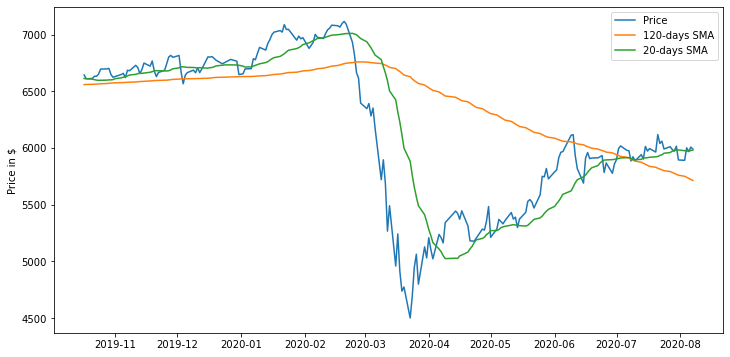

In [77]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(data['Date'], data['Adj_Close'], label='Price')
ax.plot(data['Date'], data['MovAvgPrice_120'], label = '120-days SMA')
ax.plot(data['Date'], data['MovAvgPrice_20'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')

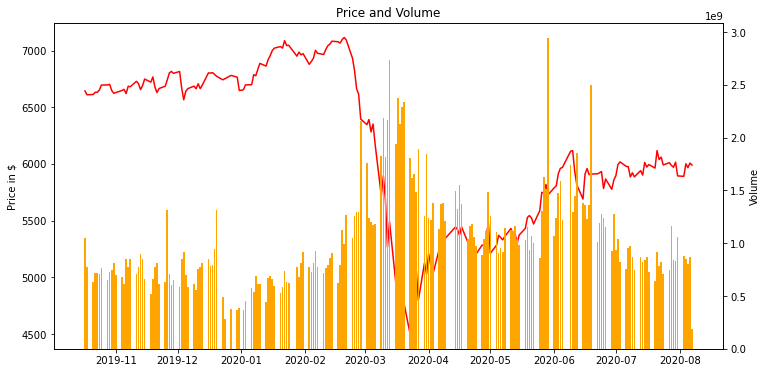

In [119]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()  # set up the 2nd axis

ax1.plot(data['Date'], data['Adj_Close'], label='Price', c='r')
ax2.bar(data['Date'], data['Volume'], label='Volume', color ='orange')

ax1.set_title('Price and Volume')
ax1.set_ylabel('Price')
ax2.set_ylabel('Volume')


ax1.set_ylabel('Price in $')
plt.show()

In [44]:
data.index = np.arange(1,len(data)+1)
data.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Month,Day,...,RatioDevPrice5toDecPrice120,RatioDevPrice5toDecPrice50,RatioAvgPrice50toAvgPrice120,RatioDevPrice50toDecPrice120,RatioAvgVol5toAvgVol120,RatioDevVol5toDecVol120,RatioAvgVol5toAvgVol50,RatioDevVol5toDecVol50,RatioAvgVol50toAvgVol120,RatioDevVol50toDecVol120
1,2019-10-17,6694.4,6695.3,6640.9,6643.9,6643.9,1.051070e+09,2019,10,17,...,0.658252,0.657766,1.000264,1.000738,0.824905,0.258255,0.824111,0.255812,1.000963,1.009552
2,2019-10-18,6643.9,6643.9,6593.9,6610.0,6610.0,7.701400e+08,2019,10,18,...,0.467501,0.463594,1.000383,1.008427,0.907139,0.817765,0.907200,0.802687,0.999933,1.018784
3,2019-10-21,6610.0,6612.8,6573.6,6612.8,6612.8,6.282900e+08,2019,10,21,...,0.376876,0.370531,1.000455,1.017123,0.935204,0.797593,0.934717,0.775596,1.000521,1.028361
4,2019-10-22,6612.8,6640.6,6608.7,6632.5,6632.5,7.199700e+08,2019,10,22,...,0.362577,0.353444,1.000519,1.025842,0.942206,0.786808,0.936854,0.767320,1.005713,1.025397
5,2019-10-23,6632.5,6633.6,6596.5,6632.2,6632.2,7.140800e+08,2019,10,23,...,0.342046,0.331266,1.000657,1.032543,0.966558,0.728257,0.961612,0.703569,1.005144,1.035089


In [54]:
corr = data.corr()
sorted_corr = abs(corr[corr['Adj_Close'] != 1]['Adj_Close']).sort_values(ascending = False)
adj_sorted_corr = sorted_corr[sorted_corr>= 0.5]
corr_index = [col_name for col_name in adj_sorted_corr.index.tolist() if col_name not in basefile_columns]

In [58]:
predictive_corr = adj_sorted_corr[corr_index]
predictive_corr

MovAvgPrice_5                   0.974180
StdDevVol_50                    0.950845
StdDevVol_90                    0.932843
MovAvgVol_20                    0.888881
RatioAvgPrice5toAvgPrice120     0.876232
MovAvgVol_50                    0.874038
StdDevVol_120                   0.873770
MovAvgPrice_20                  0.861659
RatioAvgVol50toAvgVol120        0.844652
StdDevPrice_90                  0.842711
StdDevPrice_50                  0.839110
StdDevPrice_120                 0.781049
MovAvgVol_5                     0.765840
StdDevPrice_20                  0.669419
MovAvgVol_90                    0.636244
RatioAvgPrice50toAvgPrice120    0.634691
MovAvgPrice_50                  0.624310
StdDevVol_20                    0.615506
RatioAvgPrice5toAvgPrice50      0.582220
MovAvgVol_120                   0.570984
StdDevPrice_5                   0.563258
RatioAvgVol5toAvgVol120         0.522607
Name: Adj_Close, dtype: float64

In [63]:
corr.loc[corr_index,corr_index]

,MovAvgPrice_5,StdDevVol_50,StdDevVol_90,MovAvgVol_20,RatioAvgPrice5toAvgPrice120,MovAvgVol_50,StdDevVol_120,MovAvgPrice_20,RatioAvgVol50toAvgVol120,StdDevPrice_90,...,MovAvgVol_5,StdDevPrice_20,MovAvgVol_90,RatioAvgPrice50toAvgPrice120,MovAvgPrice_50,StdDevVol_20,RatioAvgPrice5toAvgPrice50,MovAvgVol_120,StdDevPrice_5,RatioAvgVol5toAvgVol120
MovAvgPrice_5,1.000000,-0.946472,-0.958676,-0.882018,0.877414,-0.917897,-0.904569,0.926130,-0.863904,-0.890031,...,-0.699824,-0.605351,-0.682027,0.697894,0.694710,-0.578930,0.539750,-0.614347,-0.462911,-0.421878
StdDevVol_50,-0.946472,1.000000,0.932647,0.869020,-0.815933,0.853082,0.888440,-0.837194,0.771839,0.809267,...,0.732829,0.661940,0.640148,-0.536121,-0.592586,0.596166,-0.584116,0.615894,0.527137,0.485704
StdDevVol_90,-0.958676,0.932647,1.000000,0.870219,-0.767465,0.961808,0.973666,-0.947739,0.807673,0.937560,...,0.670014,0.508741,0.797475,-0.749412,-0.791917,0.623776,-0.370698,0.728711,0.395869,0.337134
MovAvgVol_20,-0.882018,0.869020,0.870219,1.000000,-0.831276,0.769244,0.812886,-0.769303,0.759141,0.773168,...,0.849129,0.738594,0.594245,-0.542758,-0.503102,0.810445,-0.595340,0.489674,0.585595,0.627229
RatioAvgPrice5toAvgPrice120,0.877414,-0.815933,-0.767465,-0.831276,1.000000,-0.672949,-0.629730,0.725385,-0.929888,-0.724505,...,-0.724476,-0.764741,-0.274866,0.559606,0.340538,-0.537810,0.790130,-0.165004,-0.591818,-0.644819
MovAvgVol_50,-0.917897,0.853082,0.961808,0.769244,-0.672949,1.000000,0.965664,-0.975468,0.790638,0.957808,...,0.536120,0.297956,0.856640,-0.833905,-0.898031,0.460534,-0.198002,0.794260,0.226357,0.163274
StdDevVol_120,-0.904569,0.888440,0.973666,0.812886,-0.629730,0.965664,1.000000,-0.927884,0.693688,0.929167,...,0.627483,0.396594,0.891401,-0.749845,-0.870219,0.585532,-0.202476,0.843059,0.315027,0.242344
MovAvgPrice_20,0.926130,-0.837194,-0.947739,-0.769303,0.725385,-0.975468,-0.927884,1.000000,-0.832169,-0.954544,...,-0.500405,-0.324980,-0.782375,0.830596,0.853195,-0.446169,0.265723,-0.713953,-0.203288,-0.147995
RatioAvgVol50toAvgVol120,-0.863904,0.771839,0.807673,0.759141,-0.929888,0.790638,0.693688,-0.832169,1.000000,0.851017,...,0.602420,0.526489,0.381407,-0.760136,-0.527543,0.401328,-0.564192,0.259475,0.406785,0.460742
StdDevPrice_90,-0.890031,0.809267,0.937560,0.773168,-0.724505,0.957808,0.929167,-0.954544,0.851017,1.000000,...,0.589146,0.353300,0.757115,-0.907209,-0.858622,0.468709,-0.203820,0.656087,0.267823,0.259464


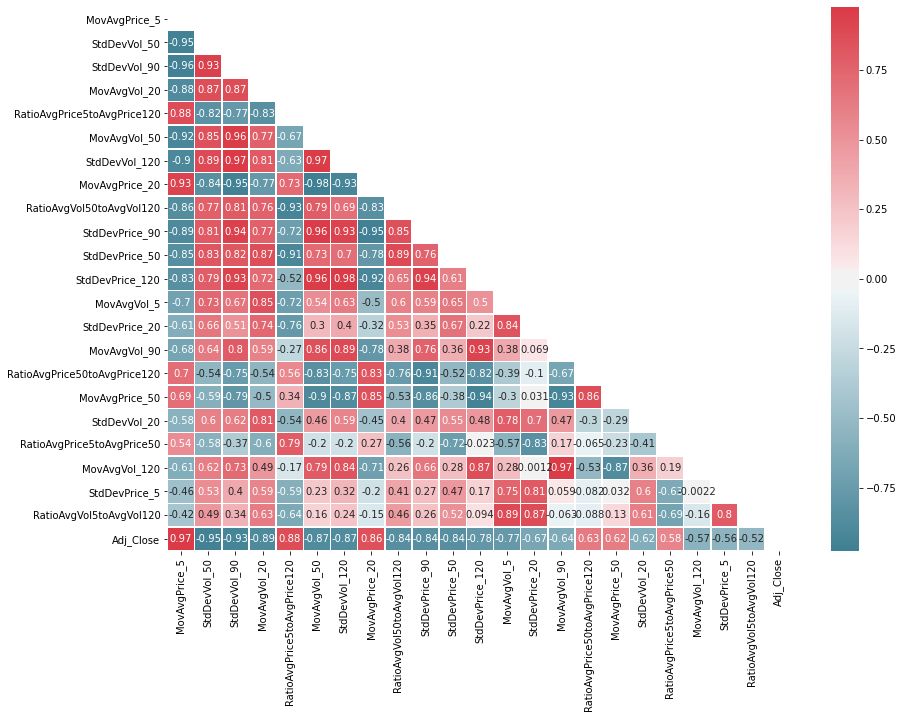

In [68]:
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(corr.loc[corr_index+['Adj_Close'],corr_index+['Adj_Close']],mask=np.triu(np.ones_like(corr.loc[corr_index+['Adj_Close'],corr_index+['Adj_Close']])),cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,linewidths=.5)

In [73]:
### Use Forward Feature Selection to pick a good model

# Take all columns except target as predictor columns
predictor_columns = [c for c in data.columns if c not in basefile_columns]
target = 'Adj_Close'

# Flag intermediate output
show_steps = True   # for testing/debugging
# show_steps = False  # without showing steps

# start with no predictors.list of the features (predictors) that were included in the model; starts empty.
included = []

# keep track of model and parameters. dictionary to keep record of the best model found at any stage; starts 'empty'.
best = {'feature': '', 'r2': 0, 'a_r2': 0}

# Create training and testing subsets
split_row = int(data.shape[0] * 0.8)
train_data = data.iloc[0:split_row]
test_data = data.iloc[split_row:]

# get the number of cases in the test data
n = test_data.shape[0]

# create a model for Linear Regression object to hold the modelling parameters
model = LinearRegression() 

## The external while loop goes forever until there are no improvements to the model, which is controlled by the flag 
## changed (until is not changed).
while True:
    changed = False
    
    if show_steps:
        print('')
    
    ## list the features to be evaluated i.e. list of features that have not been included in the model; starts as the full 
    ## list of features.
    not_included = list(set(predictor_columns) - set(included))
    
    ## for each remaining feature to be evaluated. The inner for loop goes over each of the features not yet included in 
    ## the model and calculates the correlation coefficient. If any model improves on the previous best model then the 
    ##records are updated.
    for new_column in not_included:
        
        if show_steps:
            print('(Step) Trying %s...' % new_column)
            print('(Step) - Features = %s' % ', '.join(included + [new_column]))
            
        # fit the model with the Training data. fit a model; consider which predictors should be included
        fit = model.fit(train_data[included + [new_column]], train_data[target]) 
        # calculate the score (R^2 for Regression). calculate the score
        r2 = fit.score(train_data[included + [new_column]], train_data[target]) 
        
        # number of predictors in this model
        k = len(included) + 1
        # calculate the adjusted R^2
        adjusted_r2 = 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) ) # calculate the Adjusted R^2
        
        if show_steps:
            print('(Step) - Adjusted R^2: This = %.3f; Best = %.3f' % 
                  (adjusted_r2, best['a_r2']))
       
        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True
            if show_steps:
                print('(Step) - New Best!   : Feature = %s; R^2 = %.3f; Adjusted R^2 = %.3f' % 
                      (best['feature'], best['r2'], best['a_r2']))
    ## END for
        # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        not_included = list(set(not_included) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        break

print('')
print('Resulting features:')
print(', '.join(included))


(Step) Trying MovAvgVol_5...
(Step) - Features = MovAvgVol_5
(Step) - Adjusted R^2: This = 0.632; Best = 0.000
(Step) - New Best!   : Feature = MovAvgVol_5; R^2 = 0.641; Adjusted R^2 = 0.632
(Step) Trying StdDevVol_90...
(Step) - Features = StdDevVol_90
(Step) - Adjusted R^2: This = 0.890; Best = 0.632
(Step) - New Best!   : Feature = StdDevVol_90; R^2 = 0.892; Adjusted R^2 = 0.890
(Step) Trying MovAvgPrice_90...
(Step) - Features = MovAvgPrice_90
(Step) - Adjusted R^2: This = 0.266; Best = 0.890
(Step) Trying RatioAvgVol5toAvgVol120...
(Step) - Features = RatioAvgVol5toAvgVol120
(Step) - Adjusted R^2: This = 0.369; Best = 0.890
(Step) Trying RatioAvgVol5toAvgVol50...
(Step) - Features = RatioAvgVol5toAvgVol50
(Step) - Adjusted R^2: This = 0.023; Best = 0.890
(Step) Trying RatioDevVol50toDecVol120...
(Step) - Features = RatioDevVol50toDecVol120
(Step) - Adjusted R^2: This = 0.010; Best = 0.890
(Step) Trying StdDevPrice_90...
(Step) - Features = StdDevPrice_90
(Step) - Adjusted R^2: Th

In [81]:
included

['MovAvgPrice_5',
 'Pct_Chg_Price',
 'StdDevPrice_5',
 'RatioAvgVol50toAvgVol120',
 'MovAvgPrice_20',
 'MovAvgVol_90',
 'MovAvgVol_50']

In [78]:
linRegr = LinearRegression()
linRegr.fit(train_data[included],train_data[target])
predictions = linRegr.predict(test_data[included])

In [79]:
error = np.sqrt(mean_squared_error(test_data[target],predictions))
score = r2_score(test_data[target],predictions)
print ('Error: {0:.2f}'.format(error))
print ('Score: {0:.2f}'.format(score))

Error: 319.82
Score: -14.83


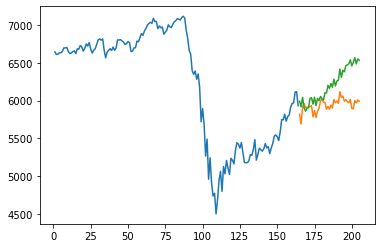

In [80]:
test = test_data.copy()
train = train_data.copy()
test['Predictions'] = 0
test['Predictions'] = predictions

test.index = data[split_row:].index
train.index = data[:split_row].index

plt.plot(train['Adj_Close'])
plt.plot(test[['Adj_Close', 'Predictions']])

Text(0, 0.5, 'Price in $')

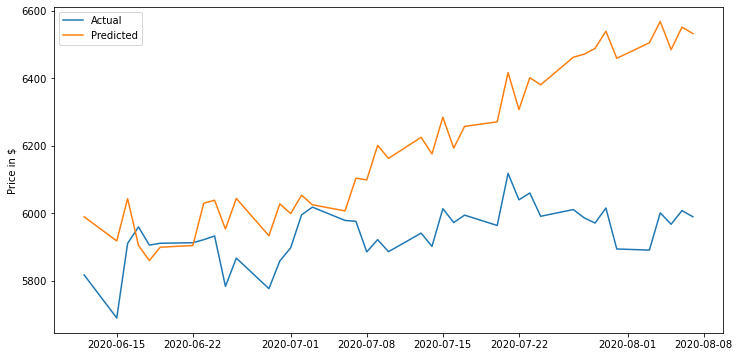

In [88]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(test['Date'], test['Adj_Close'], label='Actual')
ax.plot(test['Date'], test['Predictions'], label = 'Predicted')

ax.legend(loc='best')
ax.set_ylabel('Price in $')

In [92]:
test.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Month,Day,...,RatioDevPrice5toDecPrice50,RatioAvgPrice50toAvgPrice120,RatioDevPrice50toDecPrice120,RatioAvgVol5toAvgVol120,RatioDevVol5toDecVol120,RatioAvgVol5toAvgVol50,RatioDevVol5toDecVol50,RatioAvgVol50toAvgVol120,RatioDevVol50toDecVol120,Predictions
165,2020-06-12,5932.1,5932.1,5725.8,5817.3,5817.3,1.853590e+09,2020,6,12,...,0.289188,0.904427,0.349635,1.261332,0.377392,1.163992,0.581471,1.083626,0.649030,5989.451629
166,2020-06-15,5817.3,5829.3,5689.8,5689.8,5689.8,1.380130e+09,2020,6,15,...,0.416473,0.908276,0.347786,1.296835,0.485097,1.205651,0.750626,1.075630,0.646257,5917.899117
167,2020-06-16,5689.8,5943.1,5689.8,5910.6,5910.6,1.362100e+09,2020,6,16,...,0.611677,0.911261,0.347534,1.320721,0.422264,1.228974,0.652428,1.074653,0.647220,6043.052875
168,2020-06-17,5910.6,5959.5,5899.7,5959.5,5959.5,1.232710e+09,2020,6,17,...,0.515352,0.915027,0.350107,1.254865,0.388426,1.165477,0.599797,1.076697,0.647596,5904.758797
169,2020-06-18,5959.5,5959.5,5857.8,5905.6,5905.6,1.357710e+09,2020,6,18,...,0.362145,0.919145,0.349706,1.238063,0.414194,1.158745,0.635786,1.068452,0.651467,5859.949384


In [120]:
test['PCntChgAct'] = test['Adj_Close'].pct_change()
test['PCntChgPrd'] = test['Predictions'].pct_change()
test['Act_Status'] = test['PCntChgAct'].apply(lambda x: 'Increased' if x > 0 else 'Decreased')
test['Prd_Status'] = test['PCntChgPrd'].apply(lambda x: 'Increased' if x > 0 else 'Decreased')
a = test[test.Prd_Status == 'Decreased']['Act_Status'].value_counts()['Decreased']
b = test[test.Prd_Status == 'Decreased']['Prd_Status'].count()
c = test[test.Prd_Status == 'Increased']['Act_Status'].value_counts()['Increased']
d = test[test.Prd_Status == 'Increased']['Prd_Status'].count()
print ('When the model predicted a decrease, the price decreased {0}% of the time'.format(round(a/b*100,2)))
print ('When the model predicted a increase, the price increased {0}% of the time'.format(round(c/d*100,2)))

When the model predicted a decrease, the price decreased 83.33% of the time
When the model predicted a increase, the price increased 78.26% of the time
